In [1]:
import os
import tensorflow as tf
import glob 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator

%matplotlib inline

figsize = (5.7, 3)
export_dir = os.path.join('./image')

sns.set_theme()
sns.set_context('paper')

def get_section_results(file):
    '''
    requires tensorflow==1.12.0
    '''
    X = []
    Y = []
    Z = []
    # To see the names of the tags, use tensorboard webui to open the log
    # command: tensorboard --logdir='path/to/your/log'
    for e in summary_iterator(file):
        for v in e.summary.value:
            if v.tag == 'Train_EnvstepsSoFar':
                X.append(v.simple_value)
            elif v.tag == 'Eval_AverageReturn':
                Y.append(v.simple_value)
            elif v.tag == 'Eval_StdReturn':
                Z.append(v.simple_value)
    return X, Y, Z

# Experiment 1

In [2]:
def read_q1_data(batch: str) -> pd.DataFrame():
    '''
    @param batch: str, should be 'sb'(small batch) or 'lb'(large batch)
    '''
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'CartPole-v0' in split and batch in split:
            config_list = split[split.index(batch):split.index('CartPole-v0')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)
            # only data under current folder (3 folders each experiment)
            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
                'Eval_StdReturn': Z
            })
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            data['Eval_StdReturn'] = data['Eval_StdReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
            
    return full_data

data_sb = read_q1_data('sb')
data_lb = read_q1_data('lb')
# data_batch_list = [data_sb, data_lb]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


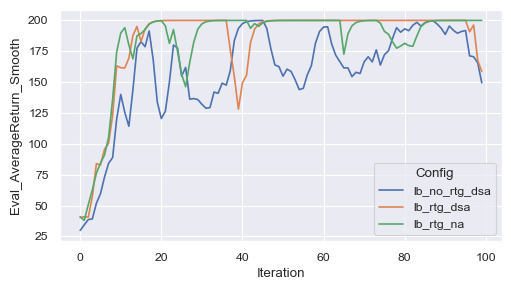

In [3]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_lb, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.savefig(os.path.join(export_dir, 'q1_lb.png'), dpi=200, bbox_inches='tight')

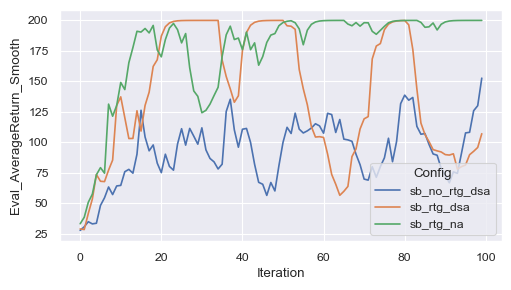

In [4]:
plt.figure(figsize=figsize)
sns.lineplot(data=data_sb, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.savefig(os.path.join(export_dir, 'q1_sb.png'),dpi=200, bbox_inches='tight')

# Experiment 2

In [5]:
def read_q2_data() -> pd.DataFrame(): 
    '''
    Return all data with all batch size and all learning rate
    '''
    full_data = pd.DataFrame()

    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'InvertedPendulum-v4' in split:
            config_list = split[split.index('q2'):split.index('InvertedPendulum-v4')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'events*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)

            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
                # 'Eval_StdReturn': Z
            })
            data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)

    return full_data

data_q2 = read_q2_data()
data_q2

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn,Eval_AverageReturn_Smooth
0,0,q2_pg_q2_b1000_r0.01,1001.0,14.321428,14.321428
1,1,q2_pg_q2_b1000_r0.01,2017.0,23.764706,21.066626
2,2,q2_pg_q2_b1000_r0.01,3018.0,40.599998,33.588019
3,3,q2_pg_q2_b1000_r0.01,4034.0,47.000000,41.846628
4,4,q2_pg_q2_b1000_r0.01,5076.0,53.750000,49.062542
...,...,...,...,...,...
895,95,q2_pg_q2_b5000_r0.1,484203.0,3.000000,3.053291
896,96,q2_pg_q2_b5000_r0.1,489204.0,3.000000,3.021316
897,97,q2_pg_q2_b5000_r0.1,494205.0,3.000000,3.008527
898,98,q2_pg_q2_b5000_r0.1,499206.0,3.000000,3.003411


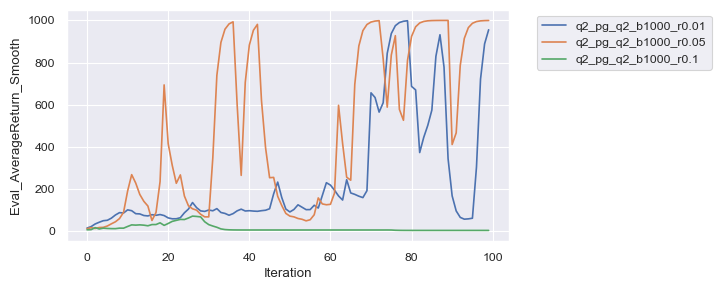

In [6]:
plt.figure(figsize=figsize)

df_b1000 = data_q2[data_q2.Config.str.contains('b1000')]

sns.lineplot(data=df_b1000, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(export_dir, 'q2_a1.png'), bbox_inches='tight', dpi=200)

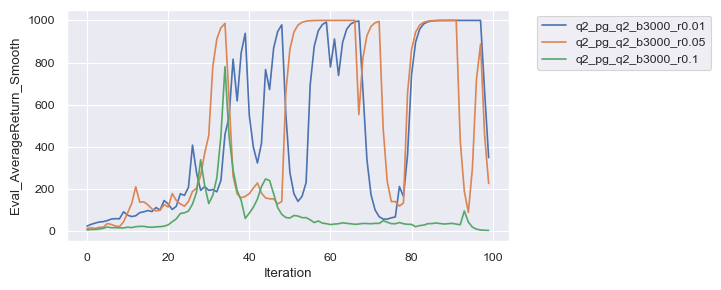

In [7]:
plt.figure(figsize=figsize)

df_b3000 = data_q2[data_q2.Config.str.contains('b3000')]

sns.lineplot(data=df_b3000, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(export_dir, 'q2_a2.png'), bbox_inches='tight', dpi=200)

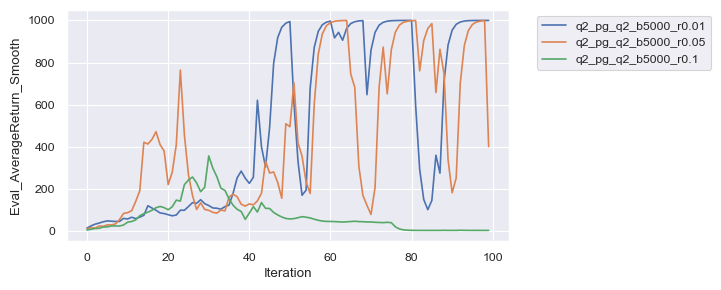

In [8]:
plt.figure(figsize=figsize)

df_b5000 = data_q2[data_q2.Config.str.contains('b5000')]

sns.lineplot(data=df_b5000, x='Iteration', y='Eval_AverageReturn_Smooth', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(export_dir, 'q2_a3.png'), bbox_inches='tight', dpi=200)
# plt.show()

From above plots, we can see the smallest batch size and largest learning rate to make the policy near optimal and stable is batch_size=5000, learning_rate=0.01

# Experiment 3

In [9]:
def read_q3_data() -> pd.DataFrame:
    full_data = pd.DataFrame()
    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'LunarLanderContinuous-v2' in split:
            config_list = split[split.index('q3'):split.index('LunarLanderContinuous-v2')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'event*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)

            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
            })

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
            
    return full_data

In [10]:
q3_data = read_q3_data()
q3_data

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn
0,0,q3_b40000_r0.005,40039.0,-156.341110
1,1,q3_b40000_r0.005,80079.0,-153.745316
2,2,q3_b40000_r0.005,120140.0,-300.962524
3,3,q3_b40000_r0.005,160217.0,-76.876236
4,4,q3_b40000_r0.005,200238.0,-74.548775
...,...,...,...,...
95,95,q3_b40000_r0.005,3875592.0,246.617554
96,96,q3_b40000_r0.005,3915921.0,219.892365
97,97,q3_b40000_r0.005,3956688.0,182.145355
98,98,q3_b40000_r0.005,3997365.0,160.997498


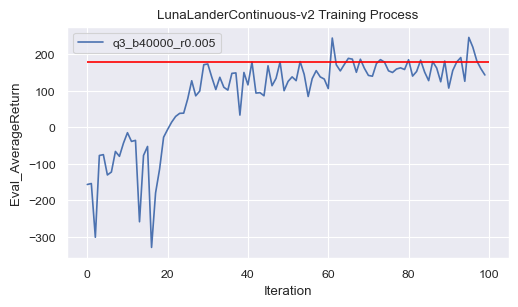

In [11]:
plt.figure(figsize=figsize)

sns.lineplot(data=q3_data, x='Iteration', y='Eval_AverageReturn', hue='Config')
plt.hlines(y=180, xmin=0, xmax=100, color='red')
plt.legend()
plt.title('LunaLanderContinuous-v2 Training Process')
plt.savefig(os.path.join(export_dir, 'q3.png'), dpi=200, bbox_inches='tight')

# Experiment 4

## Exp 4.1

In [12]:
def read_q4_1_data() -> pd.DataFrame:
    full_data = pd.DataFrame()
    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'search' in split and 'HalfCheetah-v4' in split:
            config_list = split[split.index('q4'):split.index('HalfCheetah-v4')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'event*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)

            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
            })

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)

    return full_data

q4_1_data = read_q4_1_data()
q4_1_data

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn
0,0,q4_search_b10000_lr0.005_rtg_nnbaseline,10050.0,-107.807167
1,1,q4_search_b10000_lr0.005_rtg_nnbaseline,20100.0,-78.237770
2,2,q4_search_b10000_lr0.005_rtg_nnbaseline,30150.0,-103.426842
3,3,q4_search_b10000_lr0.005_rtg_nnbaseline,40200.0,-50.871304
4,4,q4_search_b10000_lr0.005_rtg_nnbaseline,50250.0,-106.610863
...,...,...,...,...
895,95,q4_search_b50000_lr0.02_rtg_nnbaseline,4809600.0,123.827309
896,96,q4_search_b50000_lr0.02_rtg_nnbaseline,4859700.0,173.619308
897,97,q4_search_b50000_lr0.02_rtg_nnbaseline,4909800.0,126.544579
898,98,q4_search_b50000_lr0.02_rtg_nnbaseline,4959900.0,190.525986


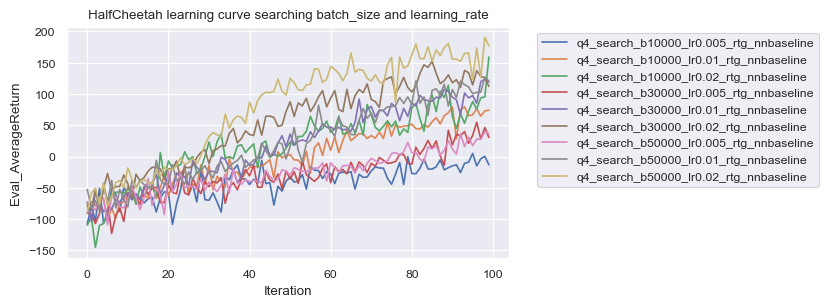

In [13]:
plt.figure(figsize=figsize)

sns.lineplot(data=q4_1_data, x='Iteration', y='Eval_AverageReturn', hue='Config')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('HalfCheetah learning curve searching batch_size and learning_rate')
plt.savefig(os.path.join(export_dir, 'q4_1.png'), dpi=200, bbox_inches='tight')

## Exp 4.2

In [17]:
def read_q4_2_data() -> pd.DataFrame:
    full_data = pd.DataFrame()
    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'q4' in split and 'HalfCheetah-v4' in split and 'search' not in split:
            config_list = split[split.index('q4'):split.index('HalfCheetah-v4')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'event*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)

            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
            })

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)

    return full_data

q4_2_data = read_q4_2_data()
q4_2_data

,Iteration,Config,Train_EnvstepsSoFar,Eval_AverageReturn
0,0,q4_b10000_r0.02,10050.0,-137.527786
1,1,q4_b10000_r0.02,20100.0,-126.259277
2,2,q4_b10000_r0.02,30150.0,-108.987022
3,3,q4_b10000_r0.02,40200.0,-107.490967
4,4,q4_b10000_r0.02,50250.0,-123.058960
...,...,...,...,...
395,95,q4_b10000_r0.02_rtg_nnbaseline,964800.0,87.946693
396,96,q4_b10000_r0.02_rtg_nnbaseline,974850.0,76.155617
397,97,q4_b10000_r0.02_rtg_nnbaseline,984900.0,93.836998
398,98,q4_b10000_r0.02_rtg_nnbaseline,994950.0,95.529930


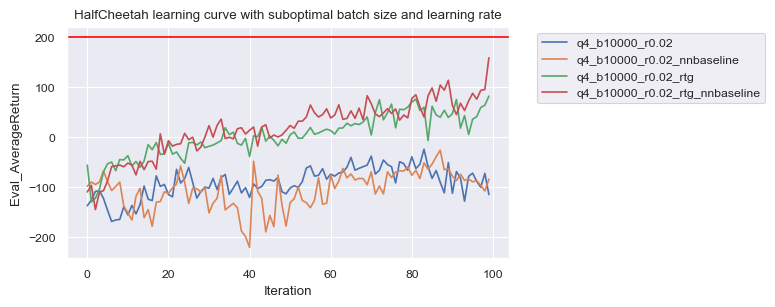

In [20]:
plt.figure(figsize=figsize)

sns.lineplot(data=q4_2_data, x='Iteration', y='Eval_AverageReturn', hue='Config')
plt.axhline(y=200, color='red')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('HalfCheetah learning curve with suboptimal batch size and learning rate')
plt.savefig(os.path.join(export_dir, 'q4_1.png'), dpi=200, bbox_inches='tight')

# Experiment 5

In [ ]:
def read_q5_data() -> pd.DataFrame:
    full_data = pd.DataFrame()
    for folder in os.listdir('data'):
        split = folder.split('_')
        if 'q5' in split and 'Hopper-v4' in split:
            config_list = split[split.index('q5'):split.index('Hopper-v4')]
            config = '_'.join(config_list)

            logdir = os.path.join('data', folder, 'event*')
            eventfile = glob.glob(logdir)[0]

            X, Y, Z = get_section_results(eventfile)

            data = pd.DataFrame({
                'Iteration': range(len(X)),
                'Config': np.repeat(config, len(X)),
                'Train_EnvstepsSoFar': X,
                'Eval_AverageReturn': Y,
            })

            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)

    return full_data

q5_data = read_q5_data()